In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import json
import copy
from tqdm import tqdm
import shutil
import os
from datetime import datetime

In [2]:
from helper_functions import remove_dataset_on_disk, count_parameters

In [3]:
torch.manual_seed(42)

In [4]:
remove_dataset_on_disk()

Removing 'data' folder


# Dataset Preparation and Augmentation

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:08<00:00, 19350957.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Image Splitting into Patches for Transformer Input

In [8]:
def create_patches(images, patch_size):
    batch_size, channels, height, width = images.shape

    assert height % patch_size == 0 and width % patch_size == 0, \
        "The image dimensions must be divisible by the patch size"

    # divides the height and width into smaller blocks
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # patches dimensions: 
    # [batch_size, channels, num_patches_height, num_patches_width, patch_size, patch_size]

    # rearrange and reshape tensor to: 
    # [batch_size, num_patches, patch_size*patch_size*channels]
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(batch_size, -1, patch_size * patch_size * channels)

    return patches

![Patches](patches_example.png)

In [9]:
def visualize_original_and_patches(images, patch_size):
    image = images[0]
    patches = create_patches(images, patch_size)
    patch_num_h = images.shape[2] // patch_size
    patch_num_w = images.shape[3] // patch_size

    # original image
    plt.figure(figsize=(5, 5))
    plt.imshow((image.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # raw patch vectors
    print(f"Raw patch vector (size {patches.shape[-1]})")
    for i in range(min(1, patches.shape[1])):
        print(f"Patch {i}: {patches[0, i].tolist()}")

    # patches in grid layout
    fig, axs = plt.subplots(patch_num_h, patch_num_w, figsize=(8, 8))
    for i in range(patch_num_h):
        for j in range(patch_num_w):
            patch_idx = i * patch_num_w + j
            patch = patches[0, patch_idx].reshape(3, patch_size, patch_size).permute(1, 2, 0)
            axs[i, j].imshow((patch * 0.5 + 0.5).clamp(0, 1))
            axs[i, j].axis('off')
    plt.suptitle("Patches in Grid Layout")
    plt.tight_layout()
    plt.show()


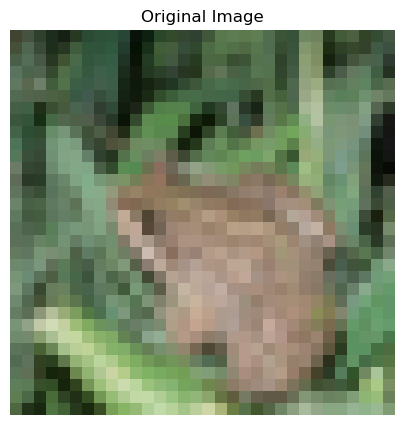

Raw patch vector (size 192)
Patch 0: [-0.4901960492134094, -0.45098036527633667, -0.6235294342041016, -0.7647058963775635, -0.8196078538894653, -0.686274528503418, -0.6549019813537598, -0.6470588445663452, -0.4588235020637512, -0.3803921341896057, -0.529411792755127, -0.7647058963775635, -0.6784313917160034, -0.4901960492134094, -0.615686297416687, -0.615686297416687, -0.427450954914093, -0.34117645025253296, -0.43529409170150757, -0.6784313917160034, -0.498039186000824, -0.41960781812667847, -0.6078431606292725, -0.5764706134796143, -0.30980390310287476, -0.4117646813392639, -0.37254899740219116, -0.5764706134796143, -0.37254899740219116, -0.46666663885116577, -0.5686274766921997, -0.5058823823928833, -0.2549019455909729, -0.3019607663154602, -0.1294117569923401, -0.4823529124259949, -0.3647058606147766, -0.5215686559677124, -0.5215686559677124, -0.46666663885116577, -0.35686272382736206, -0.3490195870399475, -0.35686272382736206, -0.3960784077644348, -0.4431372284889221, -0.545098066

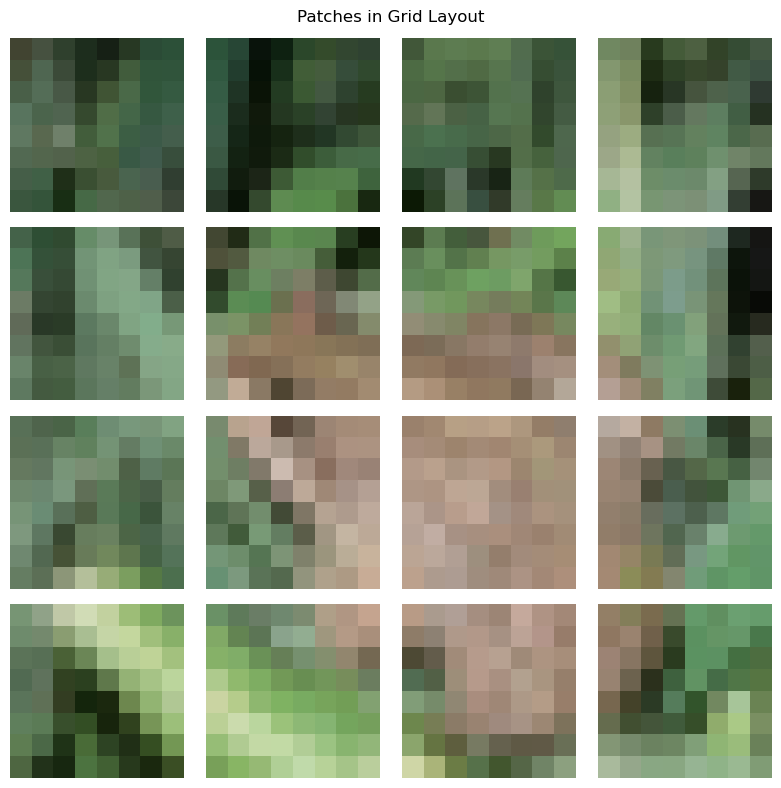

In [10]:
images, labels = next(iter(test_loader))
images = images[4:5].clone()
patch_size = 8
visualize_original_and_patches(images, patch_size)

# Visual Transformer Model

![Architecture](model_architecture.png)

In [11]:
from model_vit import VisionTransformer

In [12]:
model = VisionTransformer(
    image_size=32,
    patch_size=4,
    emb_input_channels_size=3,
    embedding_size=256,
    num_transformers=6,
    hidden_layer_dim_transformer=512,
    num_heads=8,
    num_classes=10,
    dropout_rate=0.2
)

In [13]:
model

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (mlp): Linear(in_features=48, out_features=256, bias=True)
  )
  (transformers): Sequential(
    (0): TransformerEncoder(
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (mlp_1): Linear(in_features=256, out_features=512, bias=True)
      (mlp_2): Linear(in_features=512, out_features=256, bias=True)
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (activation): GELU(approximate='none')
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoder(
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (mlp_1): Linear(in_features=256, out_features=512, bias=True)
      (mlp_2): Linear(in_

In [14]:
print(f"Total parameters: {count_parameters(model):,}")

Total parameters: 559,370


In [15]:
device = torch.device("mps")
model.to(device)
clear_output()

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 150],
    gamma=0.1
)
criterion = nn.CrossEntropyLoss()

In [17]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [18]:
os.makedirs("saved_models", exist_ok=True)

num_epochs = 160
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


In [19]:
stats = {
    "train_losses": [],
    "train_accuracies": [],
    "test_losses": [],
    "test_accuracies": []
}

In [20]:
for epoch in range(1, num_epochs + 1):
    # training
    model.train()
    running_loss = 0.0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct_train += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / (len(train_loader) * train_loader.batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # testing
    model.eval()
    running_loss = 0.0
    correct_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct_test += (preds == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_test / (len(test_loader) * test_loader.batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    stats["train_losses"] = train_losses
    stats["train_accuracies"] = train_accuracies
    stats["test_losses"] = test_losses
    stats["test_accuracies"] = test_accuracies

    # save stats to JSON file
    with open("saved_models/model_stats.json", "w") as stats_file:
        json.dump(stats, stats_file, indent=4)

    # print stats every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch}:")
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # logs
        log_entry = (
            f"Epoch {epoch}:\n"
            f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}\n"
            f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n"
        )
        with open("logs.txt", "a") as log_file:
            log_file.write(log_entry)

        # save model
        model_path = f"saved_models/model_epoch_{epoch}.pt"
        torch.save(model.state_dict(), model_path)

Epoch 10:
  Training Loss: 1.1599, Training Accuracy: 0.5850
  Test Loss: 1.1308, Test Accuracy: 0.5876
Epoch 20:
  Training Loss: 0.9882, Training Accuracy: 0.6501
  Test Loss: 0.9650, Test Accuracy: 0.6577
Epoch 30:
  Training Loss: 0.8960, Training Accuracy: 0.6827
  Test Loss: 0.8825, Test Accuracy: 0.6824
Epoch 40:
  Training Loss: 0.8453, Training Accuracy: 0.7015
  Test Loss: 0.8549, Test Accuracy: 0.6926
Epoch 50:
  Training Loss: 0.8018, Training Accuracy: 0.7139
  Test Loss: 0.8327, Test Accuracy: 0.6995
Epoch 60:
  Training Loss: 0.7796, Training Accuracy: 0.7259
  Test Loss: 0.8353, Test Accuracy: 0.7042
Epoch 70:
  Training Loss: 0.7524, Training Accuracy: 0.7339
  Test Loss: 0.8156, Test Accuracy: 0.7079
Epoch 80:
  Training Loss: 0.7292, Training Accuracy: 0.7413
  Test Loss: 0.8029, Test Accuracy: 0.7197
Epoch 90:
  Training Loss: 0.6995, Training Accuracy: 0.7515
  Test Loss: 0.7855, Test Accuracy: 0.7259
Epoch 100:
  Training Loss: 0.6813, Training Accuracy: 0.7605
  